In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

pd.set_option("display.max_colwidth", None)

In [3]:
out = {}
out_support = {}

In [4]:
COL_info_detail = ["itemsets", "support", "tn", "fp", "fn", "tp"]

COL_info = ["itemsets", "support"]

# Parameters

In [5]:
K=3

metric = "d_fpr"
t_value_col = "t_value_fp"
min_sup_divergence=0.05

In [6]:
metrics = ["d_fpr", "d_fnr", "d_accuracy", "d_error"]

In [7]:
name_output_dir = "output_compas"

In [8]:
saveFig = False

# Dataset

In [9]:
abbreviations = {
    "age_cat": "age",
    "priors_count": "#prior",
    "Greater than 45": ">45",
    "25 - 45": "25-45",
    "African-American": "Afr-Am",
    "c_charge_degree": "charge",
    "Less than 25": "<25",
    "=>": ">",
    "=<": "<",
    "length_of_stay": "stay",
    "Caucasian": "Cauc",
}

dataset_name = "compas"
risk_class_type = True

from import_datasets import import_process_compas

dfI, class_map = import_process_compas(
    risk_class=risk_class_type, continuous_col=True
)
dfI.reset_index(drop=True, inplace=True)

dfI["predicted"] = dfI["predicted"].replace({"Medium-Low": 0, "High": 1})
true_class_name, pred_class_name = "class", "predicted"
class_and_pred_names = [true_class_name, pred_class_name]
attributes = list(dfI.columns.drop(class_and_pred_names))

dfI = dfI[attributes + class_and_pred_names]
dfI.head()

,c_charge_degree,race,sex,age,priors_count,length_of_stay,class,predicted
0,F,Other,Male,69,0,1.0,0,0
1,F,African-American,Male,34,0,10.0,1,0
2,F,African-American,Male,24,4,1.0,1,0
3,M,Other,Male,44,0,1.0,0,0
4,F,Caucasian,Male,41,14,6.0,1,0


# Tree divergence - error

In [10]:
COL_info = ["itemsets", "support"]

## Tree divergence -fpr 0.025


In [11]:
cols_c = ["class", "predicted"]
continuous_attributes = ["priors_count", "length_of_stay", "age"]


type_criterion="divergence_criterion"

type_experiment = "one_at_time"

min_sup_divergence = 0.025

In [12]:
min_support_trees = [0.005, 0.01, 0.02, 0.025, 0.035, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.3]

In [13]:
max_divergence_dict = {}

for min_support_tree in min_support_trees:

    out = {}
    print(min_support_tree, end = " ")

    df_analyze = dfI.copy()

    from tree_discretization import TreeDiscretization

    tree_discr = TreeDiscretization()

    # ## Extract tree
    generalization_dict, discretizations = tree_discr.get_tree_discretization(
        df_analyze,
        type_splitting=type_experiment,
        min_support=min_support_tree,
        metric=metric,
        class_map=class_map,
        continuous_attributes=list(continuous_attributes),
        class_and_pred_names=cols_c,
        storeTree=True,
        type_criterion=type_criterion,
        # minimal_gain = 0.0015
    )
    
    considerOnlyContinuos = True
    if considerOnlyContinuos:
        for k in list(generalization_dict.keys()):
            if k not in continuous_attributes:
                generalization_dict.pop(k, None)
                
    for apply_generalization in [False, True]:
        
        if apply_generalization == True:
            type_gen = "generalized"
        else:
            type_gen = "base"
            

        from utils_extract_divergence_generalized import (
            extract_divergence_generalized,
        )

        FP_fm = extract_divergence_generalized(
            df_analyze,
            discretizations,
            generalization_dict,
            continuous_attributes,
            min_sup_divergence=min_sup_divergence,
            apply_generalization=apply_generalization,
            true_class_name=true_class_name,
            predicted_class_name=pred_class_name,
            class_map=class_map,
            FPM_type="fpgrowth",
        )

        out[type_gen] = max(FP_fm[metric])
    max_divergence_dict[min_support_tree] = out

0.005 0.01 0.02 0.025 0.035 0.05 0.075 0.1 0.125 0.15 0.175 0.2 0.25 0.3 

### Plot 

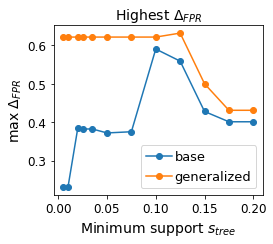

In [14]:
show_sup = [0.005, 0.01, 0.02, 0.025, 0.035, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]



from pathlib import Path
outfig_dir = "0_output_figures"
Path(outfig_dir).mkdir(parents=True, exist_ok=True)

import matplotlib.pyplot as plt



metric_name = "Δ_fpr"


vs = {}


fig, ax = plt.subplots(figsize = (4,3.5))

base = { min_support_tree: max_divergence_dict[min_support_tree]["base"] for min_support_tree in max_divergence_dict if min_support_tree in show_sup}
gen =  { min_support_tree: max_divergence_dict[min_support_tree]["generalized"] for min_support_tree in max_divergence_dict if min_support_tree in show_sup}

base = dict(sorted(base.items(), key=lambda item: item[0]))
gen = dict(sorted(gen.items(), key=lambda item: item[0]))
ax.set_title(r"Highest Δ$_{FPR}$")


ax.plot(list(base.keys()), list(base.values()), label = "base", marker = "o")
ax.plot(list(gen.keys()), list(gen.values()), label = "generalized", marker = "o")
ax.set_ylabel(r"max Δ$_{FPR}$")
ax.set_xlabel(r"Minimum support $s_{tree}$")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] ): #ax.get_xticklabels()
        item.set_fontsize(14)

for item in ax.get_xticklabels() + ax.get_yticklabels():
     item.set_fontsize(12)
        
plt.legend( fontsize = 13, handletextpad=0.2)



plt.tight_layout();
plt.savefig(f"{outfig_dir}/compas_sensitivity_s_{min_sup_divergence}.pdf");